In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
from matplotlib import pyplot as plt
print(plt.style.available)
plt.style.use('seaborn-v0_8');
import re

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [ ]:
pd.set_option('display.max_columns',0)
pd.set_option('display.max_colwidth',0)

In [ ]:
match_lvl_data = pd.read_csv('match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('bowler_level_scorecard.csv')
train_data = pd.read_csv('train_data_with_samplefeatures.csv')
# test_data = pd.read_csv('test_data_with_samplefeatures.csv')
test_data = pd.read_csv('/content/667a986f0b981_r2_data_with_samplefeatures.csv')


In [ ]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [ ]:
def createRnP(X_12, feature, N=10, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.

    Parameters-
    1. X_12: dataset to build the RnP on.
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.

    Output-
    1. Rank and Plot

    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();


In [ ]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.

    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}

    Output-None

    Returns- dataframe having bowling/batting stats from last n games of a player before an input date.
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'

    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)


### Economy of last N players

In [ ]:
def sub20ecoLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.

    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.

    Output-None

    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''

    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting bowling stats from last n games for each player.
        df_rel['sub_20_economy'] = np.where(df_rel['economy']<=20, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        res_list.append(np.nansum(df_rel['sub_20_economy']))# Sum up number of 50s for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.


In [ ]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_count_sub20eco_last15'] = train_data.progress_apply(lambda x: \
            sub20ecoLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
train_data['team2_count_sub20eco_last15'] = train_data.progress_apply(lambda x: \
            sub20ecoLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


100%|██████████| 948/948 [00:43<00:00, 21.80it/s]


In [ ]:
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_count_sub20eco_last15'] = (train_data['team1_count_sub20eco_last15']+1)/(train_data['team2_count_sub20eco_last15']+1)
train_data.drop(columns=['team1_count_sub20eco_last15','team2_count_sub20eco_last15'], inplace=True) # dropping intermediate columns


In [ ]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
test_data['team1_count_sub20eco_last15'] = test_data.progress_apply(lambda x: \
            sub20ecoLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
test_data['team2_count_sub20eco_last15'] = test_data.progress_apply(lambda x: \
            sub20ecoLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


100%|██████████| 207/207 [00:09<00:00, 21.24it/s]


In [ ]:
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
test_data['team_count_sub20eco_last15'] = (test_data['team1_count_sub20eco_last15']+1)/(test_data['team2_count_sub20eco_last15']+1)
test_data.drop(columns=['team1_count_sub20eco_last15','team2_count_sub20eco_last15'], inplace=True) # dropping intermediate columns


slope: 0.6 / 0.3 =  2.01


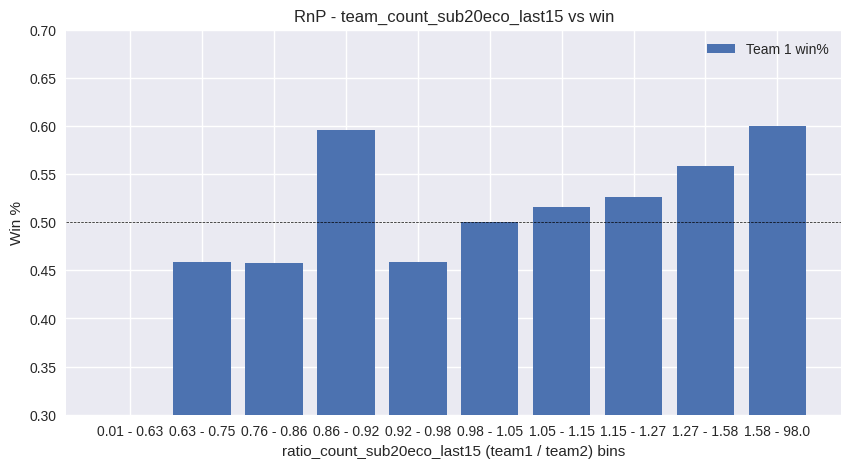

In [ ]:

createRnP(train_data, 'team_count_sub20eco_last15')

### 2 wickets in last N matches

In [ ]:
def no2WicketsLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.

    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.

    Output-None

    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''

    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting bowling stats from last n games for each player.
        df_rel['get_2_wickets'] = np.where(df_rel['wicket_count']>=2, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        res_list.append(np.nansum(df_rel['get_2_wickets']))# Sum up number of 50s for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.


In [ ]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_count_2wickets_last15'] = train_data.progress_apply(lambda x: \
            no2WicketsLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
train_data['team2_count_2wickets_last15'] = train_data.progress_apply(lambda x: \
            no2WicketsLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


100%|██████████| 948/948 [00:43<00:00, 21.89it/s]


In [ ]:
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_count_2wickets_last15'] = (train_data['team1_count_2wickets_last15']+1)/(train_data['team2_count_2wickets_last15']+1)
train_data.drop(columns=['team1_count_2wickets_last15','team2_count_2wickets_last15'], inplace=True) # dropping intermediate columns


In [ ]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
test_data['team1_count_2wickets_last15'] = test_data.progress_apply(lambda x: \
            no2WicketsLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
test_data['team2_count_2wickets_last15'] = test_data.progress_apply(lambda x: \
            no2WicketsLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


100%|██████████| 207/207 [00:09<00:00, 22.57it/s]


In [ ]:
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
test_data['team_count_2wickets_last15'] = (test_data['team1_count_2wickets_last15']+1)/(test_data['team2_count_2wickets_last15']+1)
test_data.drop(columns=['team1_count_2wickets_last15','team2_count_2wickets_last15'], inplace=True) # dropping intermediate columns


### 50 runs in last N matches

In [ ]:
# ## Feature creation

# ### 1. team_count_50runs_last15 <br>
# Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games

# In[13]:

def no50sLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.

    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.

    Output-None

    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''

    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        res_list.append(np.nansum(df_rel['gte_50runs']))# Sum up number of 50s for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.

In [ ]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
train_data['team2_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


100%|██████████| 948/948 [00:49<00:00, 19.12it/s]


In [ ]:
# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_count_50runs_last15'] = (train_data['team1_count_50runs_last15']+1)/(train_data['team2_count_50runs_last15']+1)
train_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True) # dropping intermediate columns


In [ ]:
train_data.shape
train_data.tail(2)

(948, 26)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_sub20eco_last15,team_count_2wickets_last15
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0.781818,1.166667
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,1.301587,1.157895


slope: 0.66 / 0.33 =  2.03


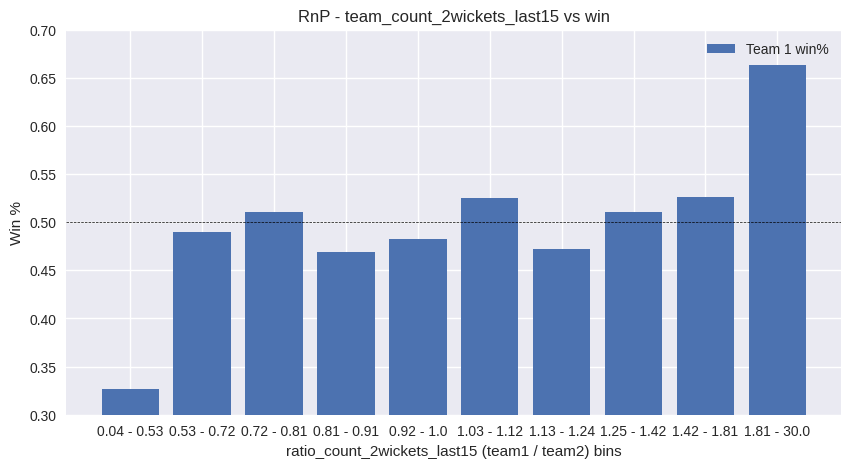

In [ ]:

createRnP(train_data, 'team_count_2wickets_last15')

slope: 0.62 / 0.38 =  1.61


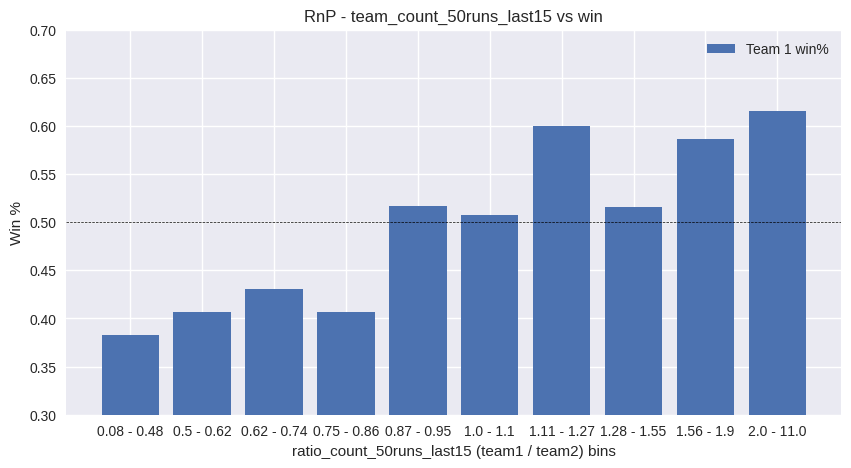

In [ ]:
# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_count_50runs_last15')

In [ ]:
## Doing similar process for test dataset

test_data['team1_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team_count_50runs_last15'] = (test_data['team1_count_50runs_last15'])/(test_data['team2_count_50runs_last15']+1)
test_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True)
test_data.shape
test_data.head(2)

100%|██████████| 207/207 [00:11<00:00, 18.06it/s]


(207, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_sub20eco_last15,team_count_2wickets_last15
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385,0.878049,1.294118
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333,0.706667,1.000000


In [ ]:
# ### 2. team_winp_last5 <br>
#
# Ratio of team1's win % to team2's win % in last 5 games

# In[20]:


def winpLastn(team_id, date, n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.

    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.

    Output- None

    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points



In [ ]:
# Compute team1's win% in last 5 games
train_data['team1_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team1_id'], x['match_dt'], 5), axis=1)
# Compute team2's win% in last 5 games
train_data['team2_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team2_id'], x['match_dt'], 5), axis=1)


100%|██████████| 948/948 [00:02<00:00, 445.20it/s]


In [ ]:
# Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
train_data['team_winp_last5'] = (train_data['team1_winp_last5']+1)/(train_data['team2_winp_last5']+1)
train_data.drop(columns=['team1_winp_last5', 'team2_winp_last5'], inplace=True) # drop intermediate columns


In [ ]:
train_data.shape
train_data.head(2)


(948, 26)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_count_sub20eco_last15,team_count_2wickets_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,1,2.033333,1.500000
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,0,0.871287,0.892857


In [ ]:
## Similar process for test data

test_data['team1_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team1_id'], date=x['match_dt'], n=5), axis=1)
test_data['team2_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team2_id'], date=x['match_dt'], n=5), axis=1)
test_data['team_winp_last5'] = (test_data['team1_winp_last5']+1)/(test_data['team2_winp_last5']+1)
test_data.drop(columns=['team1_winp_last5','team2_winp_last5'], inplace=True)
test_data.shape
test_data.head(2)

100%|██████████| 207/207 [00:00<00:00, 315.93it/s]


(207, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_sub20eco_last15,team_count_2wickets_last15
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385,0.878049,1.294118
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333,0.706667,1.000000


slope: 0.59 / 0.4 =  1.47


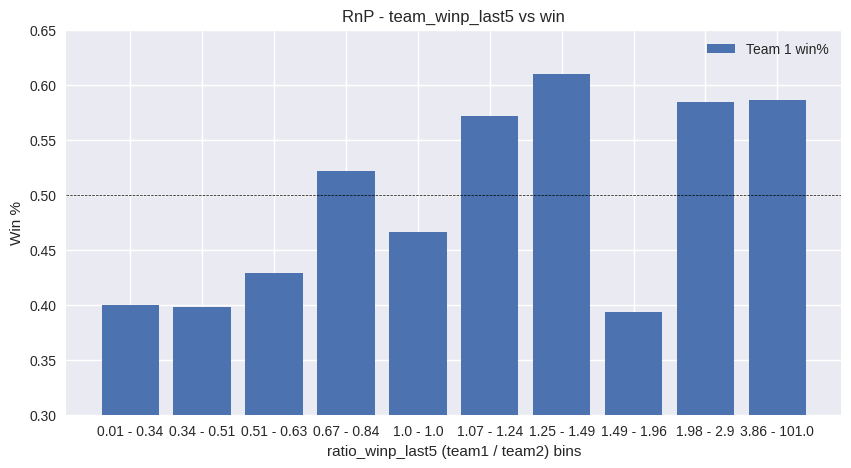

In [ ]:
# RnP of team_winp_last5 computed over the train data.
createRnP(train_data, 'team_winp_last5', ylim_ub=0.65)


slope: 0.59 / 0.4 =  1.47


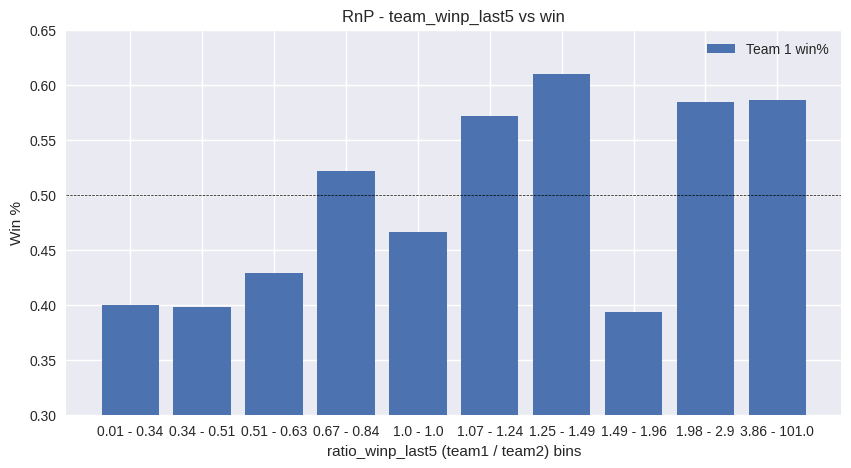

In [ ]:
# RnP of team_winp_last5 computed over the train data.
createRnP(train_data, 'team_winp_last5', ylim_ub=0.65)


In [ ]:
match_lvl_data['team1_bat_inning'] = np.where( ((match_lvl_data['team1']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='bat'))|\
                                               ((match_lvl_data['team2']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='field')) , 1, 2)


In [ ]:
def teamAvgRunsLastn(team_id, date, n):
    '''
    Function to calculate a team's average runs in their last n games.

    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.

    Output- None

    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    # combine two dataframes - one where input team is batting first, and another one where input team is batting second.
    df_rel = pd.concat([ df_rel[df_rel['team1_bat_inning']==1][['inning1_runs']].rename(columns={'inning1_runs':'runs'}), \
                         df_rel[df_rel['team1_bat_inning']==2][['inning2_runs']].rename(columns={'inning2_runs':'runs'}) ] )
    return df_rel['runs'].mean() # return mean of the combined dataframe.


In [ ]:
# Similarly for test data.
test_data['team1only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
            teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)

100%|██████████| 207/207 [00:01<00:00, 111.94it/s]


In [ ]:
# Compute average runs scored by team1 in their last 15 games for train data.
train_data['team1only_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)


100%|██████████| 948/948 [00:05<00:00, 165.38it/s]


### Function to get average win amount of each team

In [ ]:
match_lvl_data.head(2)

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,umpire1,umpire2,inning1_runs,inning1_wickets,inning1_balls,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id,team1_bat_inning
0,8638034,Nn Ds,Wn,Wn,wickets,9.0,Wn,field,By Ol,Mount Maunganui,2021-01-01,night match,Sr Sh,2020/21,17681,Dn Mw,TJ Pe,148,6,130,152.0,1.0,97.0,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0:3834305.0:3776849.0:6718340.0:3566240.0:4950364.0:7543647.0,18570,2653993.0:6718326.0:6718382.0:2486896.0:2288789.0:4950224.0:8187878.0:3083667.0:4950294.0:6718396.0:1585464.0,other_domestic,18570,NaN,1
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7.0,Sy Tr,field,Ca Ol,Carrara,2021-01-01,night match,Bg Bh Le,2020/21,6663,D Tr,PJ Ge,166,6,106,117.0,2.0,74.0,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1594319.0:7534687.0:7537067.0:1905847.0:8339701.0:7620346.0,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652.0:5788320.0:1612610.0:5509524.0:5497274.0:3876613.0:8193310.0,other_domestic,33963,1749075.0,1


In [ ]:
def teamAvgWinAmountLastn(team_id, date, n):
    '''
    Function to calculate a team's average Win Amount in their last n games.

    Input-
    1. team_id: ID of the team to calculate average win amount.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.

    Output- None

    Return- Float value denoting average of win amount by team in their last n games.
    '''
    # Filter out games with either team1_id or team2_id as the input team_id, and match date less than the current game's input date
    df_rel = match_lvl_data[(match_lvl_data['match_dt'] < date) &
                            ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))]

    # Sort by match date in descending order and take the top n rows
    df_rel = df_rel.sort_values(by='match_dt', ascending=False).head(n)

    # Filter matches where the team_id won and extract the win amount
    df_wins = df_rel[((df_rel['team1_id'] == team_id) & (df_rel['winner_id'] == team_id)) |
                     ((df_rel['team2_id'] == team_id) & (df_rel['winner_id'] == team_id))]

    # Return the average win amount
    return df_wins['win amount'].mean()

In [ ]:
# Compute team1's win% in last 5 games
train_data['team1_win_amount'] = train_data.progress_apply(lambda x: \
                                  teamAvgWinAmountLastn(x['team1_id'], x['match_dt'], 5), axis=1)
# Compute team2's win% in last 5 games
train_data['team2_win_amount'] = train_data.progress_apply(lambda x: \
                                  teamAvgWinAmountLastn(x['team2_id'], x['match_dt'], 5), axis=1)

# Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
train_data['team_win_amount'] = (train_data['team1_win_amount']+1)/(train_data['team2_win_amount']+1)
train_data.drop(columns=['team1_win_amount', 'team2_win_amount'], inplace=True) # drop intermediate columns

100%|██████████| 948/948 [00:04<00:00, 230.58it/s]


In [ ]:
# Compute team1's win% in last 5 games
test_data['team1_win_amount'] = test_data.progress_apply(lambda x: \
                                  teamAvgWinAmountLastn(x['team1_id'], x['match_dt'], 5), axis=1)
# Compute team2's win% in last 5 games
test_data['team2_win_amount'] = test_data.progress_apply(lambda x: \
                                  teamAvgWinAmountLastn(x['team2_id'], x['match_dt'], 5), axis=1)

# Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
test_data['team_win_amount'] = (test_data['team1_win_amount']+1)/(test_data['team2_win_amount']+1)
test_data.drop(columns=['team1_win_amount', 'team2_win_amount'], inplace=True) # drop intermediate columns

100%|██████████| 207/207 [00:00<00:00, 300.37it/s]


### Function to get win percentage for team in a series

In [ ]:
# def series_team_win_percentage(team_id, series_name, date):
#     '''
#     Function to calculate a team's win percentage in the current series.

#     Input-
#     1. team_id: ID of the team to calculate win percentage.
#     2. series_name: Name of the series for which the feature is calculated.
#     3. date: Match date of the current game for which the feature is calculated.

#     Output- None

#     Return- Float value denoting win percentage of the team in the current series.
#     '''
#     # Filter the matches played in the current series and before the given date
#     df_series = match_lvl_data[(match_lvl_data['series_name'] == series_name) &
#                                (match_lvl_data['match_dt'] < date) &
#                                ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))]

#     # Calculate the total number of games played by the team in the series
#     total_games = len(df_series)

#     # Calculate the number of wins by the team in the series
#     wins = len(df_series[df_series['winner_id'] == team_id])

#     # Calculate and return the win percentage
#     return (wins / total_games) * 100 if total_games > 0 else 0

In [ ]:
# # Compute team1's win% in last 5 games
# train_data['team1_swinp'] = train_data.progress_apply(lambda x: \
#                                   series_team_win_percentage(x['team1_id'], x['match_dt'], 5), axis=1)
# # Compute team2's win% in last 5 games
# train_data['team2_swinp'] = train_data.progress_apply(lambda x: \
#                                   series_team_win_percentage(x['team2_id'], x['match_dt'], 5), axis=1)

# # Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
# train_data['team_swinp'] = (train_data['team1_swinp']+1)/(train_data['team2_swinp']+1)
# train_data.drop(columns=['team1_swinp', 'team2_swinp'], inplace=True) # drop intermediate columns

### Function to Calculate Average Runs Scored by a Team at a Ground

In [ ]:
# def avg_runs_at_ground(team_id, ground_id, date, n):
#     '''
#     Function to calculate a team's average runs scored at a ground in the last n games.

#     Input-
#     1. team_id: ID of the team to calculate average runs.
#     2. ground_id: ID of the ground.
#     3. date: Match date of the current game for which the feature is calculated.
#     4. n: Look-back window of games for the team.

#     Output- None

#     Return- Float value denoting average runs scored by the team at the ground in the last n games.
#     '''
#     # Filter the matches played at the specified ground before the given date
#     df_ground = match_lvl_data[(match_lvl_data['ground_id'] == ground_id) &
#                                (match_lvl_data['match_dt'] < date) &
#                                ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))]

#     # Sort by match date in descending order and take the top n rows
#     df_ground = df_ground.sort_values(by='match_dt', ascending=False).head(n)

#     # Calculate average runs scored by the team
#     df_ground['team_runs'] = df_ground.apply(lambda row: row['team1_runs'] if row['team1_id'] == team_id else row['team2_runs'], axis=1)

In [ ]:
# # Compute team1's win% in last 5 games
# train_data['team1_avg_runs_ground'] = train_data.progress_apply(lambda x: \
#                                   avg_runs_at_ground(x['team1_id'], x['ground_id'], x['match_dt'], 5), axis=1)
# # Compute team2's win% in last 5 games
# train_data['team1_avg_runs_ground'] = train_data.progress_apply(lambda x: \
#                                   avg_runs_at_ground(x['team2_id'], x['ground_id'], x['match_dt'], 5), axis=1)

# # Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
# train_data['team_avg_runs_ground'] = (train_data['team1_avg_runs_ground']+1)/(train_data['team2_avg_runs_ground']+1)
# train_data.drop(columns=['team1_avg_runs_ground', 'team2_avg_runs_ground'], inplace=True) # drop intermediate columns

### Function to Calculate Win Percentage of a Team at a Ground

In [ ]:
def win_percentage_at_ground(team_id, ground_id, date):
    '''
    Function to calculate a team's win percentage at a ground.

    Input-
    1. team_id: ID of the team to calculate win percentage.
    2. ground_id: ID of the ground.
    3. date: Match date of the current game for which the feature is calculated.

    Output- None

    Return- Float value denoting win percentage of the team at the ground.
    '''
    # Filter the matches played at the specified ground before the given date
    df_ground = match_lvl_data[(match_lvl_data['ground_id'] == ground_id) &
                               (match_lvl_data['match_dt'] < date) &
                               ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))]

    # Calculate the total number of games played by the team at the ground
    total_games = len(df_ground)

    # Calculate the number of wins by the team at the ground
    wins = len(df_ground[df_ground['winner_id'] == team_id])

    # Calculate and return the win percentage
    return (wins / total_games) * 100 if total_games > 0 else 0

In [ ]:
# Compute team1's win% in last 5 games
train_data['team1_winp_ground'] = train_data.progress_apply(lambda x: \
                                  win_percentage_at_ground(x['team1_id'], x['ground_id'], x['match_dt']), axis=1)
# Compute team2's win% in last 5 games
train_data['team2_winp_ground'] = train_data.progress_apply(lambda x: \
                                  win_percentage_at_ground(x['team2_id'], x['ground_id'], x['match_dt']), axis=1)

# Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
train_data['team_winp_ground'] = (train_data['team1_winp_ground']+1)/(train_data['team2_winp_ground']+1)
train_data.drop(columns=['team1_winp_ground', 'team2_winp_ground'], inplace=True) # drop intermediate columns

100%|██████████| 948/948 [00:01<00:00, 480.74it/s]


In [ ]:
# Compute team1's win% in last 5 games
test_data['team1_winp_ground'] = test_data.progress_apply(lambda x: \
                                  win_percentage_at_ground(x['team1_id'], x['ground_id'], x['match_dt']), axis=1)
# Compute team2's win% in last 5 games
test_data['team2_winp_ground'] = test_data.progress_apply(lambda x: \
                                  win_percentage_at_ground(x['team2_id'], x['ground_id'], x['match_dt']), axis=1)

# Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
test_data['team_winp_ground'] = (test_data['team1_winp_ground']+1)/(test_data['team2_winp_ground']+1)
test_data.drop(columns=['team1_winp_ground', 'team2_winp_ground'], inplace=True) # drop intermediate columns

100%|██████████| 207/207 [00:00<00:00, 483.61it/s]


### Function to Calculate Average Wickets Lost by Team in Last n Matches

In [ ]:
# def team_avg_wickets_lost_last_n(team_id, date, n=15):
#     '''
#     Function to calculate average wickets lost by the team in the last n matches.

#     Input-
#     1. team_id: ID of the team to calculate average wickets lost.
#     2. date: Match date of the current game for which the feature is calculated.
#     3. n: Look-back window of games for the team.

#     Output- None
#     #
#     Return- Float value denoting average wickets lost by the team in their last n games.
#     '''
#     # Filter the matches played before the given date
#     df_team = match_lvl_data[(match_lvl_data['match_dt'] < date) &
#                              ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))]
#     # Sort the matches by date and take the last n matches
#     df_team = df_team.sort_values(by='match_dt', ascending=False).head(n)

#     # Calculate wickets lost by the team
#     df_team['wickets_lost'] = df_team.apply(lambda x: x['team1_wickets'] if x['team1_id'] == team_id else x['team2_wickets'], axis=1)

#     # Calculate the average wickets lost
#     avg_wickets_lost = df_team['wickets_lost'].mean()

#     return avg_wickets_lost

In [ ]:
# # Compute team1's win% in last 5 games
# train_data['team1_avg_wkt_lost'] = train_data.progress_apply(lambda x: \
#                                   team_avg_wickets_lost_last_n(x['team1_id'], x['match_dt'], 5), axis=1)
# # Compute team2's win% in last 5 games
# train_data['team2_avg_wkt_lost'] = train_data.progress_apply(lambda x: \
#                                   team_avg_wickets_lost_last_n(x['team2_id'], x['match_dt'], 5), axis=1)

# # Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
# train_data['team2_avg_wkt_lost'] = (train_data['team1_avg_wkt_lost']+1)/(train_data['team2_avg_wkt_lost']+1)
# train_data.drop(columns=['team1_avg_wkt_lost', 'team2_avg_wkt_lost'], inplace=True) # drop intermediate columns

### Function to Calculate Team's Performance Against Opponent

In [ ]:
# def team_win_percentage_against_opponent(team_id, opponent_id):
#     '''
#     Function to calculate historical win percentage of a team against a specific opponent.

#     Input-
#     1. team_id: ID of the team for which win percentage is calculated.
#     2. opponent_id: ID of the opponent team.

#     Output- None

#     Return- Float value denoting win percentage of the team against the specific opponent.
#     '''
#     # Filter matches where team1_id is team_id and team2_id is opponent_id
#     df_team1_vs_opponent = match_lvl_data[(match_lvl_data['team1_id'] == team_id) &
#                                           (match_lvl_data['team2_id'] == opponent_id)]

#     # Filter matches where team2_id is team_id and team1_id is opponent_id
#     df_team2_vs_opponent = match_lvl_data[(match_lvl_data['team2_id'] == team_id) &
#                                           (match_lvl_data['team1_id'] == opponent_id)]

#     # Concatenate both dataframes
#     df_matches = pd.concat([df_team1_vs_opponent, df_team2_vs_opponent])

#     # Calculate total matches played against opponent
#     total_matches = len(df_matches)

#     if total_matches == 0:
#         return 0.0

#     # Calculate matches won by team_id against opponent_id
#     matches_won = df_matches[df_matches['winner_id'] == team_id].shape[0]

#     # Calculate win percentage
#     win_percentage = (matches_won / total_matches) * 100.0

#     return win_percentage

### Function to Calculate Average Experience of Players in the Team

In [ ]:
# def team_avg_player_experience(team_id):
#     '''
#     Function to calculate average experience (number of matches played) of the players in the team.

#     Input-
#     1. team_id: ID of the team for which average experience is calculated.

#     Output- None

#     Return- Float value denoting average number of matches played by players in the team.
#     '''
#     # Extract roster IDs of players in the team
#     roster_ids_str = match_lvl_data[match_lvl_data['team1_id'] == team_id]['team1_roster_ids'].iloc[0]
#     roster_ids = list(map(int, roster_ids_str.split(':')))

#     # Filter batsman and bowler datasets to get matches played by players in roster_ids
#     df_batsman_team = batsman_data[batsman_data['batsman_id'].isin(roster_ids)]
#     df_bowler_team = bowler_data[bowler_data['bowler_id'].isin(roster_ids)]

#     # Calculate total matches played by players in roster_ids
#     total_matches = df_batsman_team['match_id'].nunique() + df_bowler_team['match_id'].nunique()

#     if total_matches == 0:
#         return 0.0

#     # Calculate average number of matches played
#     avg_matches_played = total_matches / len(roster_ids)

#     return avg_matches_played

In [ ]:
# ### 4. teamone_winp_teamtwo_last15 <br>
# Team1's win percentage againts Team2 in last 15 games

# In[33]:


def winpCrossLastn(team1_id, team2_id, date, n):
    '''
    Function to compute team1's win% against team2 from the current game in their past n encounters.

    Input-
    1. team1_id: ID of team1 to calculate win% of.
    2. team2_id: ID of team2 to calculate win% against.
    3: date: match date of the current game for which the feature is to be calculated.
    4. n: look-back window of games for both these teams.

    Output- None

    Returns- Float value denoting team1's win% against team2 in their past n games against each other.
    '''
    # filter out games where either team1_id is input team1 and team2_id is input team2, or where team2_id is input team1 and team1_id is input team2.
    # Also, match date is less than current games's input date, sort desc by date and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      (((match_lvl_data['team1_id']==team1_id)&(match_lvl_data['team2_id']==team2_id))|((match_lvl_data['team1_id']==team2_id)&(match_lvl_data['team2_id']==team1_id)))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    win_count = df_rel[df_rel['winner_id']==team1_id].shape[0] # Counting number of rows (games) where winner is input team1.
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return Float denoting team1's win% against team2 in past n games rounded to 2 decimal places.



In [ ]:
# Compute team1 win% against team2 in their past 15 encounters for train data.
train_data['team1_winp_team2_last15'] = train_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)


100%|██████████| 948/948 [00:02<00:00, 333.46it/s]


In [ ]:
test_data['team1_winp_team2_last15'] = test_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)


100%|██████████| 207/207 [00:00<00:00, 268.26it/s]


In [ ]:
# ### 5. ground_avg_runs_last15 <br>
# average runs scored in the ground in last 15 games

# In[38]:


def avgRunsGround(ground_id, date, n):
    '''
    Function to calculate average runs scored in ground/venue.

    Input-
    1. ground_id: ID of the ground to calculate the feature for.
    2. date: match date of the current game to calculate the feature for.
    3. n: look-back window of games for the ground.

    Output- None

    Returns- Average runs scored in the ground.
    '''
    # filter out games with ground_id being the input ground_id and date earlier than current game's input date. Sort desc by date, and select top n rows (games).
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&(match_lvl_data['ground_id']==ground_id)].sort_values(by='match_dt', ascending=False).head(n)
    df_rel['avg_runs_inn'] = (df_rel['inning1_runs']+df_rel['inning2_runs'])/2 # take the mean of inning1_runs and inning2_runs in a separate column.
    return df_rel['avg_runs_inn'].mean() # Return the mean value of the computed column above.



In [ ]:
## Calculate average runs in the ground for last 15 games hosted in that venue for train data.
train_data['ground_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)
## Similarly for test data.
test_data['ground_avg_runs_last15'] = test_data.progress_apply(lambda x: \
                                  avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)


100%|██████████| 207/207 [00:00<00:00, 409.74it/s]


In [ ]:
train_data.drop(columns=['winner_01'], inplace=True) # Dropping intermediate column made to plot RnP.


In [ ]:
train_data.head(2)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_count_sub20eco_last15,team_count_2wickets_last15,team_win_amount,team_winp_ground
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,2.033333,1.500000,0.424528,0.504950
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,0.871287,0.892857,1.800000,0.009901


In [ ]:
# ## Save

# In[57]:


train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_datar2.csv', index=False)
